In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Input
from tensorflow.keras import backend as K

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

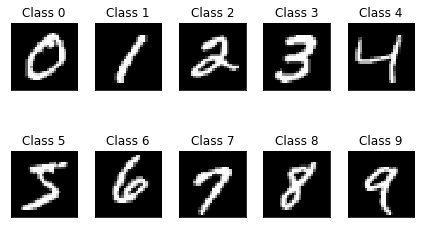

In [42]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


In [43]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


In [0]:
def generator():
  model = Sequential()
  
  model.add(Dense(256*7*7, use_bias=False, input_shape = (100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256)
  
  model.add(Conv2DTranspose(128, (5,5), strides = (1, 1), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  assert model.output_shape == (None, 7, 7, 128)
  
  model.add(Conv2DTranspose(64, (5,5), strides = (2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  assert model.output_shape == (None, 14, 14, 64)
  
  model.add(Conv2DTranspose(1, (5,5), strides = (2, 2), padding='same', activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)
  
  print(model.summary())
  
  return model

In [0]:
def discriminator():
  model = Sequential()

  model.add(Conv2D(32, (5,5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(256, (5,5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  
  print(model.summary())

  return model

            

In [46]:
gen_model = generator()
dis_model = discriminator()
dis_model.compile(loss = 'binary_crossentropy', optimizer = Optimizer.Adam(lr=0.0003), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 7, 128)         0         
__________

In [0]:
discriminator.trainable = False

noise = Input(shape=(100,))
gen_output = gen_model(noise)
decision = dis_model(gen_output)
gan = Model(inputs=noise, outputs=decision) 

In [0]:
gan.compile(optimizer=Optimizer.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

epoch = 1/100, d_loss=0.253, g_loss=7.559                                                                                                     


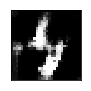

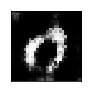

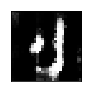

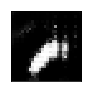

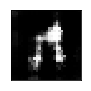

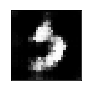

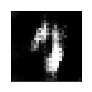

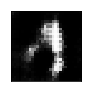

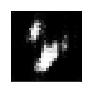

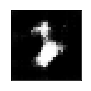

In [0]:
epochs = 100

smooth = 0.1
batch_size = 64

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

dis_loss = []
gan_loss = []

for e in range(epochs+1):
  for i in range(len(X_train) // batch_size):
    discriminator.trainable = True

    # Real samples given to discriminator
    X_batch = X_train[i*batch_size:(i+1)*batch_size]
    d_loss_real = dis_model.train_on_batch(x=X_batch, y=real * (1 - smooth))

    #Fake images are generated by generator and are fed again to discriminator
    z = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
    X_fake = gen_model.predict_on_batch(z)
    d_loss_fake = dis_model.train_on_batch(x=X_fake, y=fake)

    #Calculating overall loss
    d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

    # Train Generator weights
    dis_model.trainable = False
    d_g_loss_batch = gan.train_on_batch(x=z, y=real)


    print(
          'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
          100*' ',
          end='\r'
          )

  dis_loss.append(d_loss_batch)
  gan_loss.append(d_g_loss_batch[0])
  print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, dis_loss[-1], gan_loss[-1]), 100*' ')

  if e % 10 == 0:
    samples = 10
    x_fake = gen_model.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

    for k in range(samples):
      plt.subplot(2, 5, k+1)
      plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
      plt.xticks([])
      plt.yticks([])

    plt.tight_layout()
    plt.show()
  